In [53]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tlo import Date
from tlo.analysis.utils import (
    extract_results,
    summarize,
)
import geopandas as gpd

In [54]:
results_folder = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs-2025-11-17T080947Z_mode_2_ssp_585')

output_folder = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs-2025-11-17T080947Z_mode_2_ssp_585')

In [55]:
climate_sensitivity_analysis = False
parameter_sensitivity_analysis = False
main_text = False
mode_2 = True
if climate_sensitivity_analysis:

    suffix = "climate_SA"
    scenarios_of_interest = range(len(scenario_names_all))
    scenario_names = scenario_names_all
if parameter_sensitivity_analysis:
    scenario_names = range(0, 9, 1)
    scenarios_of_interest = scenario_names

    suffix = "parameter_SA"
if main_text:
    scenario_names = [
        "Baseline",
        "SSP 2.45 Mean",
    ]
    suffix = "main_text"
    scenarios_of_interest = [0, 6]

if mode_2:
    scenario_names = [
        "Baseline",
        "SSP 5.85 Mean",
    ]
    suffix = "mode_2"
    scenarios_of_interest = [0, 1]

In [56]:
scenario_names

['Baseline', 'SSP 5.85 Mean']

In [57]:
mode_2

True

In [58]:

min_year = 2025
max_year = 2027
spacing_of_years = 1
PREFIX_ON_FILENAME = '1'

scenario_names_all = ["baseline", "ssp126_highest", "ssp126_lowest", "ssp126_mean", "ssp245_highest", "ssp245_lowest", "ssp245_mean",  "ssp585_highest", "ssp585_lowest", "ssp585_mean"]

scenario_colours = ['#0081a7', '#00afb9', '#FEB95F', '#fed9b7', '#f07167']*4


vmin = 0.5e+06
vmax = 2.4e+06


Helper functions

In [59]:
target_year_sequence = range(min_year, max_year, spacing_of_years)

def get_num_treatments_total(_df):
        _df['date'] = pd.to_datetime(_df['date'])

        # filter to target period
        _df = _df.loc[_df['date'].between(*TARGET_PERIOD)]
        total = {}

        for d in _df['hsi_event_key_to_counts']:
            for k, v in d.items():
                total[k] = 0
                total[k] += total.get(k, 0) + v
        return pd.Series(sum(total.values()), name="total_treatments")

def get_num_treatments_never_ran(_df):
        _df['date'] = pd.to_datetime(_df['date'])

        # filter to target period
        _df = _df.loc[_df['date'].between(*TARGET_PERIOD)]
        total = {}

        for d in _df['never_ran_hsi_event_key_to_counts']:
            for k, v in d.items():
                total[k] = 0
                total[k] += total.get(k, 0) + v
        return pd.Series(sum(total.values()), name="total_treatments")


def get_num_treatments_total_delayed(_df):
        _df['date'] = pd.to_datetime(_df['date'])

        # filter to target period
        _df = _df.loc[_df['date'].between(*TARGET_PERIOD)]
        total = {}

        for d in _df['weather_delayed_hsi_event_key_to_counts']:
            for k, v in d.items():
                total[k] = 0
                total[k] += total.get(k, 0) + v
        return pd.Series(sum(total.values()), name="total_treatments")

def get_num_treatments_total_cancelled(_df):
        _df['date'] = pd.to_datetime(_df['date'])

        # filter to target period
        _df = _df.loc[_df['date'].between(*TARGET_PERIOD)]
        total = {}

        for d in _df['weather_cancelled_hsi_event_key_to_counts']:
            for k, v in d.items():
                total[k] = 0
                total[k] += total.get(k, 0) + v
        return pd.Series(sum(total.values()), name="total_treatments")

def get_population_for_year(_df):
        """Returns the population in the year of interest"""
        _df['date'] = pd.to_datetime(_df['date'])
        filtered_df = _df.loc[_df['date'].between(*TARGET_PERIOD)]
        numeric_df = filtered_df.drop(columns=['female', 'male'], errors='ignore')
        population_sum = numeric_df.sum(numeric_only=True)
        return population_sum

def get_num_dalys_by_cause_label(_df):
        """Return total number of DALYS (Stacked) by label (total by age-group within the TARGET_PERIOD)"""
        return (
            _df.loc[_df.year.between(*[i.year for i in TARGET_PERIOD])]
            .drop(columns=["date", "sex", "age_range", "year"])
            .sum()
        )



In [ ]:
import matplotlib.dates as mdates

# We need to store delayed and cancelled data separately in the main loop
# Add these dictionaries after all_scenarios_appointment_difference_*
all_scenarios_appointment_delayed_mean = {}
all_scenarios_appointment_cancelled_mean = {}
all_scenarios_dalys_mean = {}

# Then in your main loop (for draw in range(len(scenario_names))),
# add this after calculating the difference:
for draw in range(len(scenario_names)):
    
    all_years_data_delayed_mean = {}
    all_years_data_cancelled_mean = {}
    all_years_dalys_mean = {}

    for target_year in target_year_sequence:
        TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))
        
        if draw == 0:
            all_years_data_delayed_mean[target_year] = pd.Series([0], name='mean')
            all_years_data_cancelled_mean[target_year] = pd.Series([0], name='mean')
        else:
            # Calculate proportions separately
            num_delayed = summarize(extract_results(
                results_folder,
                module='tlo.methods.healthsystem.summary',
                key='weather_delayed_hsi_event_counts',
                custom_generate_series=get_num_treatments_total_delayed,
                do_scaling=True
            ), only_mean=False, collapse_columns=True)[draw]
            
            num_cancelled = summarize(extract_results(
                results_folder,
                module='tlo.methods.healthsystem.summary',
                key='weather_cancelled_hsi_event_counts',
                custom_generate_series=get_num_treatments_total_cancelled,
                do_scaling=True
            ), only_mean=False, collapse_columns=True)[draw]
            
            num_total = summarize(extract_results(
                results_folder,
                module='tlo.methods.healthsystem.summary',
                key='hsi_event_counts',
                custom_generate_series=get_num_treatments_total,
                do_scaling=True
            ), only_mean=False, collapse_columns=True)[draw]
            
            num_dalys = summarize(extract_results(
                results_folder,
                module='tlo.methods.healthburden',
                key='dalys_stacked',
                custom_generate_series=get_num_dalys_by_cause_label,
                do_scaling=True
            ), only_mean=False, collapse_columns=True)[draw]
            print(num_dalys['mean'].sum())
            
            all_years_data_delayed_mean[target_year] = num_delayed['mean'] / num_total['mean']
            all_years_data_cancelled_mean[target_year] = num_cancelled['mean'] / num_total['mean']
            all_years_dalys_mean[target_year] = num_dalys['mean'].sum()

    all_scenarios_appointment_delayed_mean[scenario_names[draw]] = all_years_data_delayed_mean
    all_scenarios_appointment_cancelled_mean[scenario_names[draw]] = all_years_data_cancelled_mean
    all_scenarios_dalys_mean[scenario_names[draw]] = all_years_dalys_mean


Plots

ValueError: x and y must have same first dimension, but have shapes (15,) and (390,)

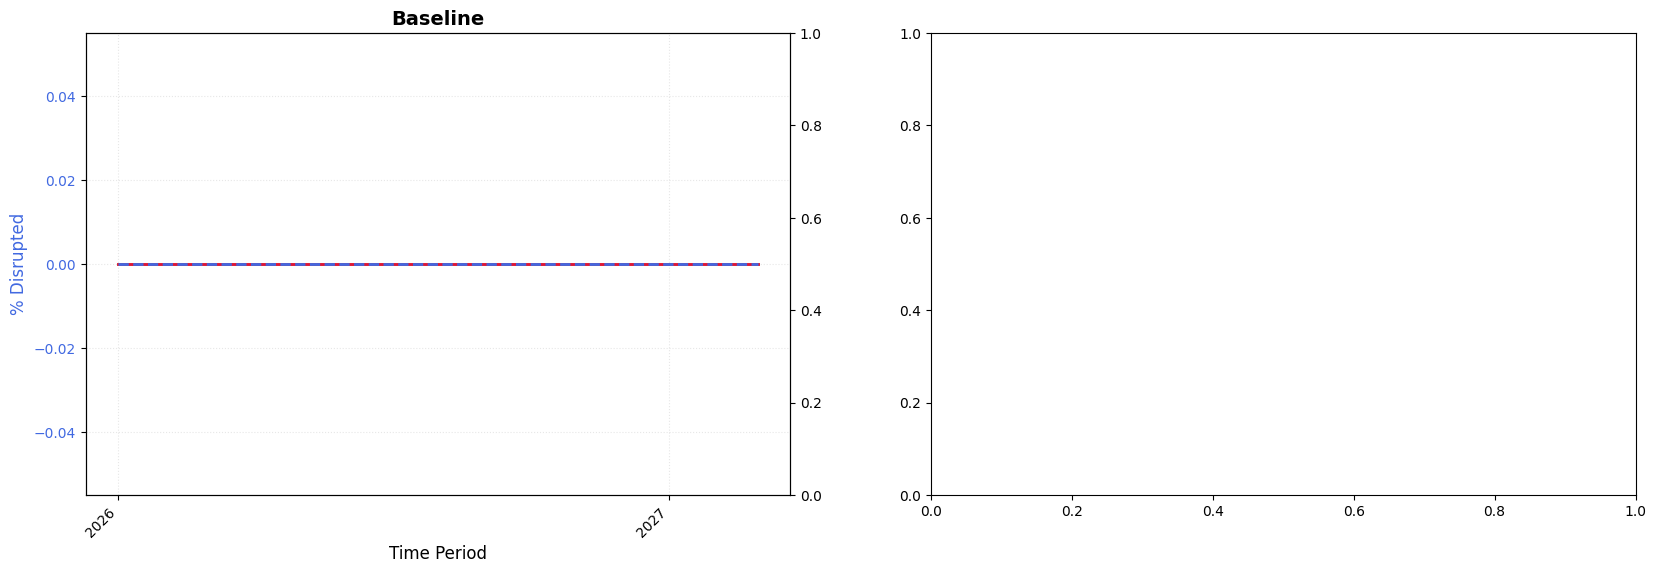

In [51]:

# Now create the plots with dual y-axes
appointment_delayed_scenarios = {}
appointment_cancelled_scenarios = {}
daly_scenarios = {}

for scenario_name in scenario_names:
    if scenario_name == "Baseline":
        baseline_length = len(target_year_sequence)
        appointment_delayed_scenarios[scenario_name] = [0.0] * baseline_length
        appointment_cancelled_scenarios[scenario_name] = [0.0] * baseline_length
        
        dalys_all_years = [
            value for year in daly_by_scenario.keys()
            for value in daly_by_scenario[year].values.tolist()
        ]
        daly_scenarios[scenario_name] = dalys_all_years
        continue
    
    if main_text:
        if "ssp245" not in scenario_name:
            continue
        
    delayed_by_scenario = all_scenarios_appointment_delayed_mean[scenario_name]
    cancelled_by_scenario = all_scenarios_appointment_cancelled_mean[scenario_name]
    daly_by_scenario = all_scenarios_dalys_mean[scenario_name]

    delayed_all_years = [
        value for year in delayed_by_scenario.keys()
        for value in delayed_by_scenario[year].values.tolist()
    ]
    cancelled_all_years = [
        value for year in cancelled_by_scenario.keys()
        for value in cancelled_by_scenario[year].values.tolist()
    ]
    
    dalys_all_years = [
        value for year in daly_by_scenario.keys()
        for value in daly_by_scenario[year].values.tolist()
    ]
    
    appointment_delayed_scenarios[scenario_name] = delayed_all_years
    appointment_cancelled_scenarios[scenario_name] = cancelled_all_years
    daly_scenarios[scenario_name] = dalys_all_years

if main_text:
    scenario_names_filtered = [name for name in appointment_delayed_scenarios.keys() if "ssp245" in name]
else:
    scenario_names_filtered = scenario_names

n_scenarios = len(scenario_names_filtered)
n_cols = min(3, n_scenarios)
n_rows = (n_scenarios + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
if n_scenarios == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_scenarios > 1 else [axes]

for i, scenario_name in enumerate(scenario_names_filtered):
    ax1 = axes[i]
    
    delayed_data = np.array(appointment_delayed_scenarios[scenario_name], dtype=float) * 100
    cancelled_data = np.array(appointment_cancelled_scenarios[scenario_name], dtype=float) * 100
    total_data = delayed_data + cancelled_data
    daly_data = np.array(daly_scenarios[scenario_name], dtype=float)
    
    n_months = len(delayed_data)
    start_date = pd.date_range(start='2026-01', periods=n_months, freq='MS')
    
    # Plot appointment disruptions on primary y-axis
    line1 = ax1.plot(start_date, delayed_data, label="Delayed", linewidth=2, color='#FF8C00')
    line2 = ax1.plot(start_date, cancelled_data, label="Cancelled", linewidth=2, color='#DC143C')
    line3 = ax1.plot(start_date, total_data, label="Total Disrupted", linewidth=2, color='#4169E1', linestyle='--')
    
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax1.set_xlabel("Time Period", fontsize=12)
    ax1.set_ylabel("% Disrupted", fontsize=12, color='#4169E1')
    ax1.tick_params(axis='y', labelcolor='#4169E1')
    ax1.set_title(f"{scenario_name}", fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle=':')
    
    # Create secondary y-axis for DALYs
    ax2 = ax1.twinx()
    line4 = ax2.plot(start_date, daly_data, label="DALYs", linewidth=2, color='#2E8B57', linestyle='-.')
    ax2.set_ylabel("DALYs", fontsize=12, color='#2E8B57')
    ax2.tick_params(axis='y', labelcolor='#2E8B57')
    
    # Combine legends from both axes
    lines = line1 + line2 + line3 + line4
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best', fontsize=10)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig(output_folder / f"{PREFIX_ON_FILENAME}_delayed_cancelled_dalys.png", dpi=300, bbox_inches='tight')
plt.show()


In [52]:
390/12

32.5

Add in weather for these

In [ ]:
ssps = ["ssp245"]
models = ["lowest", "mean", "highest"]
service = "ANC"

for ssp_scenario in ssps:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))

    for i, model_type in enumerate(models):
        ax = axes[i]
        weather_data_prediction_monthly_original = pd.read_csv(
            f"/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/Downscaled_CMIP6_data_CIL/{ssp_scenario}/{model_type}_monthly_prediction_weather_by_facility_{service}.csv",
            dtype={'column_name': 'float64'}
        )
        
        mask = (weather_data_prediction_monthly_original.index > 23) & \
               (weather_data_prediction_monthly_original.index < (10*22))
        weather_data_prediction_monthly_original = weather_data_prediction_monthly_original.loc[mask].reset_index(drop=True)

        weather_data_prediction_monthly_average_facilities = weather_data_prediction_monthly_original.iloc[:, 1:].mean(axis=1)

        yearly_precip = weather_data_prediction_monthly_average_facilities.groupby(weather_data_prediction_monthly_average_facilities.index // 12).sum()
        
        scenario_name = f"{ssp_scenario}_{model_type}"    
        delayed_data = np.array(appointment_delayed_scenarios[scenario_name], dtype=float) * 100
        cancelled_data = np.array(appointment_cancelled_scenarios[scenario_name], dtype=float) * 100
        total_data = delayed_data + cancelled_data
        
        n_years = len(delayed_data)
        start_date = pd.date_range(start='2026-01', periods=n_years, freq='Y')

        # Plot precipitation on primary y-axis
        color_precip = '#009DDC'
        ax.plot(start_date, yearly_precip[2:], label='Precipitation', color=color_precip, linewidth=2, linestyle='--')
        ax.set_xlabel("Year")
        ax.set_ylabel("Cumulative precipitation (mm)", color=color_precip)
        ax.tick_params(axis='y', labelcolor=color_precip)
        
        # Create secondary y-axis for appointment disruptions
        ax2 = ax.twinx()
        ax2.plot(start_date, delayed_data, label="Delayed", linewidth=2, color='#FF8C00')
        ax2.plot(start_date, cancelled_data, label="Cancelled", linewidth=2, color='#DC143C')
        ax2.plot(start_date, total_data, label="Total Disrupted", linewidth=2, color='black')
        ax2.set_ylabel("Appointment Disruption (%)")
        ax2.tick_params(axis='y')
        
        ax.set_title(f"{ssp_scenario}, {model_type}")
        
        # Combine legends from both axes
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='best')
        
    plt.tight_layout()
    plt.show()

Now only mean for main text 

In [ ]:
ssps = ["ssp245"]
model_type = "mean"  # only the middle panel
service = "ANC"

for ssp_scenario in ssps:
    fig, ax = plt.subplots(figsize=(12, 6))  # single panel
    
    # Load weather data
    weather_data_prediction_monthly = pd.read_csv(
        f"/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/Downscaled_CMIP6_data_CIL/{ssp_scenario}/{model_type}_monthly_prediction_weather_by_facility_{service}.csv",
        dtype={'column_name': 'float64'}
    )

    # Subset relevant months
    mask = (weather_data_prediction_monthly.index > 23) & \
           (weather_data_prediction_monthly.index < (10*22))
    weather_data_prediction_monthly = weather_data_prediction_monthly.loc[mask].reset_index(drop=True)

    # Average across facilities
    weather_data_avg = weather_data_prediction_monthly.iloc[:, 1:].mean(axis=1)

    # Yearly cumulative precipitation
    yearly_precip = weather_data_avg.groupby(weather_data_avg.index // 12).sum()

    # Load appointment disruption data
    scenario_name = f"{ssp_scenario}_{model_type}"    
    delayed_data = np.array(appointment_delayed_scenarios[scenario_name], dtype=float) * 100
    cancelled_data = np.array(appointment_cancelled_scenarios[scenario_name], dtype=float) * 100
    total_data = delayed_data + cancelled_data

    n_years = len(delayed_data)
    start_date = pd.date_range(start='2026-01', periods=n_years, freq='Y')

    # Plot precipitation on primary y-axis
    color_precip = '#1C6E8C'
    ax.plot(start_date, yearly_precip[2:], label='Precipitation', color=color_precip,
            linewidth=2, linestyle='--')
    ax.set_xlabel("Year")
    ax.set_ylabel("Cumulative Precipitation (mm)", color=color_precip)
    ax.tick_params(axis='y', labelcolor=color_precip)
    ax.grid(False)

    # Secondary y-axis for appointment disruptions
    ax2 = ax.twinx()
    ax2.plot(start_date, delayed_data, label="Delayed", linewidth=2, color='#FEB95F')
    ax2.plot(start_date, cancelled_data, label="Cancelled", linewidth=2, color='#f07167')
    ax2.plot(start_date, total_data, label="Total Disrupted", linewidth=2, color='#5A716A')
    ax2.set_ylabel("Appointment Disruption (%)", rotation = -90, labelpad=25)
    ax2.tick_params(axis='y')

    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False)
    ax.text(-0.0, 1.05, '(C)', transform=ax.transAxes,
                   fontsize=14, va='top', ha='right')
    plt.tight_layout()
    plt.show()

Get predicted disruptions from linear model

In [ ]:
climate_ssps = ["ssp126", "ssp245", "ssp585"]
climate_model_ensemble_models = ["lowest", "mean", "highest"]

climate_all_scenarios = {}
climate_summary_stats = {}

for ssp in climate_ssps:
    for model in climate_model_ensemble_models:
        scenario_key = f"{ssp}_{model}"
        
        df = pd.read_csv(
            f'/Users/rem76/PycharmProjects/TLOmodel/resources/climate_change_impacts/'
            f'ResourceFile_Precipitation_Disruptions_{ssp}_{model}.csv'
        )
        df = df[(df["year"] > 2025) & (df["year"] <= 2041)]
        
        # average per year-month
        avg_df = df.groupby(["year", "month"], as_index=False)["mean_all_service"].mean()
        values = avg_df["mean_all_service"].values.tolist()
        
        # store full time series
        climate_all_scenarios[scenario_key] = values
        
        # compute summary statistics
        climate_summary_stats[scenario_key] = {
            "min": float(avg_df["mean_all_service"].min()) ,
            "max": float(avg_df["mean_all_service"].max()) ,
            "mean": float(avg_df["mean_all_service"].mean() )
        }



Plot predicted vs modelled disruptions

In [ ]:
appointment_all_scenarios = {}
for scenario_name in scenario_names:
    if scenario_name == "Baseline":
        continue
    appointment_by_scenario = all_scenarios_appointment_difference_mean[scenario_name]
    for year in appointment_by_scenario.keys():
            appointment_all_years = [
        value
        for year in appointment_by_scenario.keys()
        for value in appointment_by_scenario[year].values.tolist()
    ]
        
    appointment_all_scenarios[scenario_name] = appointment_all_years


scenario_names = [name for name in appointment_all_scenarios.keys() if name != "baseline"]

fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = axes.flatten()  # Flatten to easily index

for i, scenario_name in enumerate(scenario_names):
    ax = axes[i]
    ax.plot(np.array(appointment_all_scenarios[scenario_name], dtype=float) * 0.6, label="TLO")
    ax.plot(climate_all_scenarios[scenario_name], label="Predicted")
    
    ax.set_xlabel("Year")
    ax.set_ylabel("Value")
    ax.set_title(f"{scenario_name}")
    ax.grid(True)
    ax.legend()

In [ ]:
import matplotlib.dates as mdates
appointment_all_scenarios = {}
for scenario_name in scenario_names:
    if scenario_name == "Baseline":
        continue
    # Filter for only SSP 2.45 scenarios
    if "ssp245" not in scenario_name:
        continue
        
    appointment_by_scenario = all_scenarios_appointment_difference_mean[scenario_name]
    # Collect all values across all years
    appointment_all_years = [
        value
        for year in appointment_by_scenario.keys()
        for value in appointment_by_scenario[year].values.tolist()
    ]
        
    appointment_all_scenarios[scenario_name] = appointment_all_years

# Filter scenario names for SSP 2.45
scenario_names_filtered = [name for name in appointment_all_scenarios.keys() if "ssp245" in name]

# Adjust subplot grid based on number of SSP 2.45 scenarios
n_scenarios = len(scenario_names_filtered)
n_cols = min(3, n_scenarios)
n_rows = (n_scenarios + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
if n_scenarios == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_scenarios > 1 else [axes]

for i, scenario_name in enumerate(scenario_names_filtered):
    ax = axes[i]
    # Convert to % by multiplying by 100
    data_points = np.array(appointment_all_scenarios[scenario_name], dtype=float) * 100
    
    # Create month labels starting from Jan 2012
    n_months = len(data_points)
    start_date = pd.date_range(start='2026-01', periods=n_months, freq='MS')
    
    ax.plot(start_date, data_points, label="TLO % Delayed")
    
    # Format x-axis to show dates nicely
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax.set_xlabel("Time Period")
    ax.set_ylabel("% Disrupted")
    ax.set_title(f"{scenario_name}")
    ax.grid(False)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()

In [ ]:
 ssps = ["ssp126", "ssp245", "ssp585"]
models = ["lowest", "mean", "highest"]
service = "ANC"

for ssp_scenario in ssps:
    plt.figure(figsize=(12, 6))
    
    for model_type in models:
        weather_data_prediction_monthly_original = pd.read_csv(
            f"/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/Downscaled_CMIP6_data_CIL/{ssp_scenario}/{model_type}_monthly_prediction_weather_by_facility_{service}.csv",
            dtype={'column_name': 'float64'}
        )
        
        mask = (weather_data_prediction_monthly_original.index > 23) & \
               (weather_data_prediction_monthly_original.index < (12*18))
        weather_data_prediction_monthly_original = weather_data_prediction_monthly_original.loc[mask].reset_index(drop=True)

        weather_data_prediction_monthly_average_facilities = weather_data_prediction_monthly_original.iloc[:, 1:].mean(axis=1)
        plt.plot(weather_data_prediction_monthly_average_facilities, label=model_type)
    
    plt.xticks(ticks=range(0,int(len(weather_data_prediction_monthly_original)), 12), labels=range(2026, 2026 + int(len(weather_data_prediction_monthly_original)/12), 1))
    plt.title(f"Predicted Monthly Weather by Facility – {ssp_scenario}")
    plt.xlabel("Month")
    plt.ylabel("Predicted Weather")
    plt.legend()
    plt.show()